# pomegranate / sklearn Naive Bayes comparison

authors: <br>
Nicholas Farn (nicholasfarn@gmail.com) <br>
Jacob Schreiber (jmschreiber91@gmail.com)

<a href="https://github.com/scikit-learn/scikit-learn">sklearn</a> is a very popular machine learning package for Python which implements a wide variety of classical machine learning algorithms. In this notebook we benchmark the Naive Bayes implementations in pomegranate and compare it to the implementation in sklearn.

In [1]:
%pylab inline
import seaborn, time
seaborn.set_style('whitegrid')

from sklearn.naive_bayes import GaussianNB
from pomegranate import *

Populating the interactive namespace from numpy and matplotlib


Lets first define a function which will create a dataset to train on. We want to be able to test a range of datasets, from very small to very large, to see which implementation is faster. We also want a function which will take in the models and evaluate them. Lets define both of those now.

In [2]:
def create_dataset(n_samples, n_dim, n_classes):
    """Create a random dataset with n_samples in each class."""
    
    X = numpy.concatenate([numpy.random.randn(n_samples, n_dim) + i for i in range(n_classes)])
    y = numpy.concatenate([numpy.zeros(n_samples) + i for i in range(n_classes)])
    return X, y

def plot( fit, predict, skl_error, pom_error, sizes, xlabel ):
    """Plot the results."""
    
    idx = numpy.arange(fit.shape[1])
    
    plt.figure( figsize=(14, 4))
    plt.plot( fit.mean(axis=0), c='c', label="Fitting")
    plt.plot( predict.mean(axis=0), c='m', label="Prediction")
    plt.plot( [0, fit.shape[1]], [1, 1], c='k', label="Baseline" )
    
    plt.fill_between( idx, fit.min(axis=0), fit.max(axis=0), color='c', alpha=0.3 )
    plt.fill_between( idx, predict.min(axis=0), predict.max(axis=0), color='m', alpha=0.3 )
    
    plt.xticks(idx, sizes, rotation=65, fontsize=14)
    plt.xlabel('{}'.format(xlabel), fontsize=14)
    plt.ylabel('pomegranate is x times faster', fontsize=14)
    plt.legend(fontsize=12, loc=4)
    plt.show()
    
    
    plt.figure( figsize=(14, 4))
    plt.plot( 1 - skl_error.mean(axis=0), alpha=0.5, c='c', label="sklearn accuracy" )
    plt.plot( 1 - pom_error.mean(axis=0), alpha=0.5, c='m', label="pomegranate accuracy" )
    
    plt.fill_between( idx, 1-skl_error.min(axis=0), 1-skl_error.max(axis=0), color='c', alpha=0.3 )
    plt.fill_between( idx, 1-pom_error.min(axis=0), 1-pom_error.max(axis=0), color='m', alpha=0.3 )
    
    plt.xticks( idx, sizes, rotation=65, fontsize=14)
    plt.xlabel( '{}'.format(xlabel), fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=14) 
    plt.show()
    
def evaluate_models( skl, pom ):
    sizes = numpy.around( numpy.exp( numpy.arange(8, 16) ) ).astype('int')
    n, m = sizes.shape[0], 20
    
    skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))
    
    for i in range(m):
        for j, size in enumerate(sizes):
            X, y = create_dataset( size, 1, 2 )
            
            # bench fit times
            tic = time.time()
            skl.fit( X, y )
            skl_fit[i, j] = time.time() - tic

            tic = time.time()
            pom.fit( X, y )
            pom_fit[i, j] = time.time() - tic

            # bench predict times
            tic = time.time()
            skl_predictions = skl.predict( X )
            skl_predict[i, j] = time.time() - tic

            tic = time.time()
            pom_predictions = pom.predict( X )
            pom_predict[i, j] = time.time() - tic
        
            # check number wrong
            skl_e = (y != skl_predictions).mean()
            pom_e = (y != pom_predictions).mean()

            skl_error[i, j] = min(skl_e, 1-skl_e)
            pom_error[i, j] = min(pom_e, 1-pom_e)
    
    fit = skl_fit / pom_fit
    predict = skl_predict / pom_predict
    
    plot(fit, predict, skl_error, pom_error, sizes, "samples per component")

Lets look first at single dimension Gaussian datasets. We'll look at how many times faster pomegranate is, which means that values > 1 show pomegranate is faster and < 1 show pomegranate is slower. Lets also look at the accuracy of both algorithms. They should have the same accuracy since they implement the same algorithm.

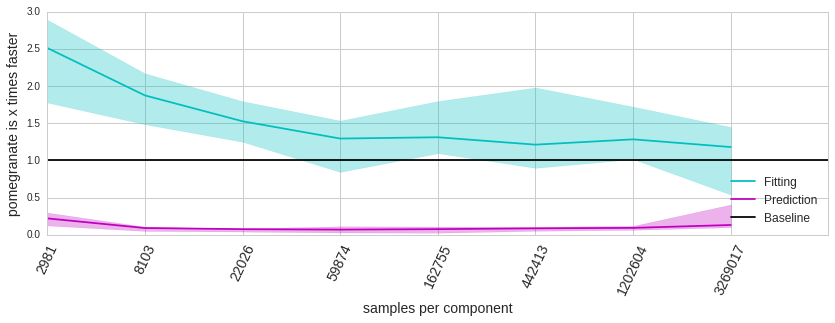

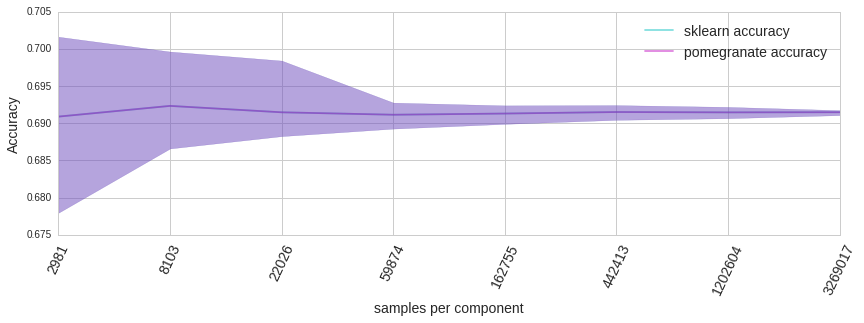

In [3]:
skl = GaussianNB()
pom = NaiveBayes( NormalDistribution )
evaluate_models( skl, pom )

It looks as if pomegranate has a significant speed improvement for small models, likely through having a smaller initialization cost. Even on large datasets it can be faster to fit models. While it is significantly slower at making predictions these times are usually so small that they are insignificant anyway.


Now lets look if they scale as more classes are added, instead of just binary classification, with a total of 50,000 samples across all classes.

In [11]:
def evaluate_models( skl, pom ):
    sizes = numpy.arange(2, 21).astype('int')
    n, m = sizes.shape[0], 20
    
    skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))
    
    for i in range(m):
        for j, size in enumerate(sizes):
            X, y = create_dataset( 50000 / size, 1, size )
            
            # bench fit times
            tic = time.time()
            skl.fit( X, y )
            skl_fit[i, j] = time.time() - tic

            tic = time.time()
            pom.fit( X, y )
            pom_fit[i, j] = time.time() - tic

            # bench predict times
            tic = time.time()
            skl_predictions = skl.predict( X )
            skl_predict[i, j] = time.time() - tic

            tic = time.time()
            pom_predictions = pom.predict( X )
            pom_predict[i, j] = time.time() - tic
        
            # check number wrong
            skl_e = (y != skl_predictions).mean()
            pom_e = (y != pom_predictions).mean()

            skl_error[i, j] = min(skl_e, 1-skl_e)
            pom_error[i, j] = min(pom_e, 1-pom_e)
    
    fit = skl_fit / pom_fit
    predict = skl_predict / pom_predict
    
    plot(fit, predict, skl_error, pom_error, sizes, "number of classes")

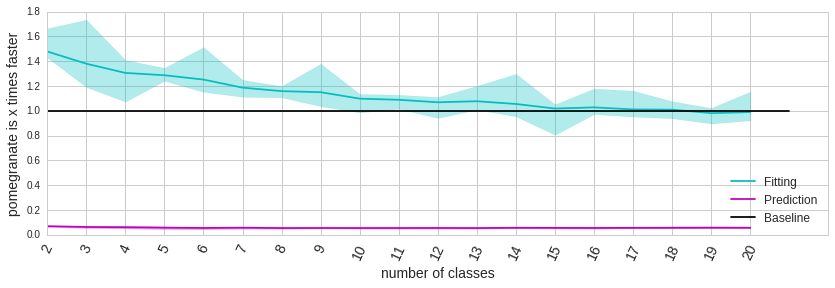

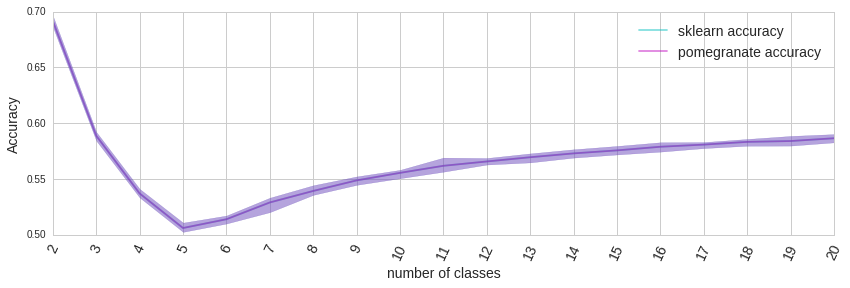

In [12]:
skl = GaussianNB()
pom = NaiveBayes( NormalDistribution )
evaluate_models( skl, pom )

It looks like pomegranate initially starts off as faster fitting the model with a small number of classes, but that this speed increase becomes insignificant as most classes are added, converging to roughly sklearn's speed. However, sklearn remains faster at making predictions. Lets take a look at the raw time it takes to make predictions though.

In [13]:
X, y = create_dataset( 50000, 1, 2 )
skl = GaussianNB()
skl.fit(X, y)

pom = NaiveBayes( NormalDistribution )
pom.fit(X, y)

%timeit skl.predict(X)
%timeit pom.predict(X)

100 loops, best of 3: 3.07 ms per loop
10 loops, best of 3: 45 ms per loop


This does show that sklearn is significantly faster at this step. However, predicting 100,000 points in 45ms is sufficient for most applications. 

More commonly multivariate Gaussian emissions are used. scikit-learn supports this with the same estimator and pomegranate supports this with plugging in a different distribution. Lets look at increasing the number of samples again with a default of 5 dimensions.

In [6]:
def evaluate_models( skl, pom ):
    sizes = numpy.around( numpy.exp( numpy.arange(8, 16) ) ).astype('int')
    n, m = sizes.shape[0], 20
    
    skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))
    
    for i in range(m):
        for j, size in enumerate(sizes):
            X, y = create_dataset( size, 5, 2 )
            
            # bench fit times
            tic = time.time()
            skl.fit( X, y )
            skl_fit[i, j] = time.time() - tic

            tic = time.time()
            pom.fit( X, y )
            pom_fit[i, j] = time.time() - tic

            # bench predict times
            tic = time.time()
            skl_predictions = skl.predict( X )
            skl_predict[i, j] = time.time() - tic

            tic = time.time()
            pom_predictions = pom.predict( X )
            pom_predict[i, j] = time.time() - tic
        
            # check number wrong
            skl_e = (y != skl_predictions).mean()
            pom_e = (y != pom_predictions).mean()

            skl_error[i, j] = min(skl_e, 1-skl_e)
            pom_error[i, j] = min(pom_e, 1-pom_e)
    
    fit = skl_fit / pom_fit
    predict = skl_predict / pom_predict
    
    plot(fit, predict, skl_error, pom_error, sizes, "samples per component")

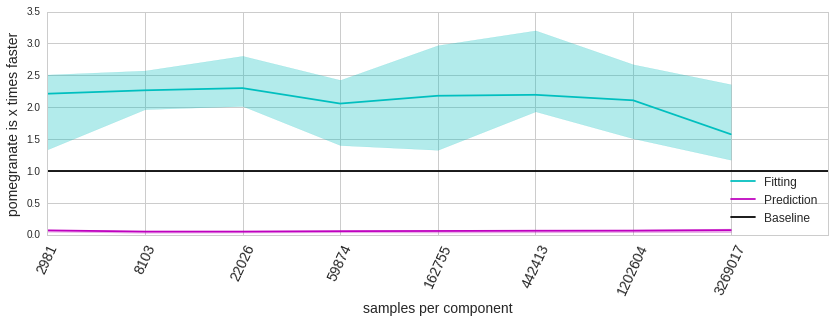

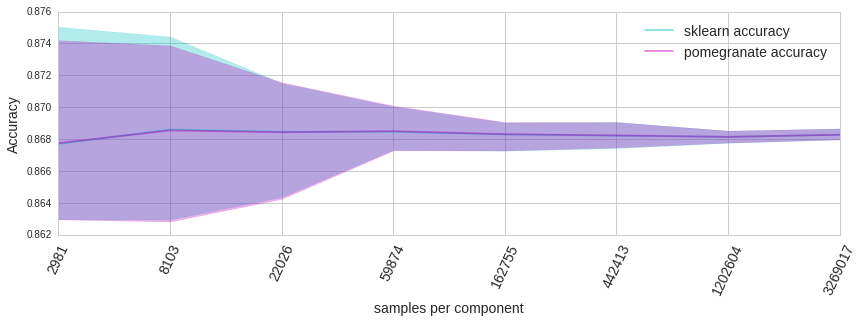

In [7]:
skl = GaussianNB()
pom = NaiveBayes( MultivariateGaussianDistribution )
evaluate_models( skl, pom )

It looks like pomegranate can be several times faster at fitting multivariate Gaussian Naive Bayes models than sklearn is, with a speed that doesn't decay too much as the dataset gets larger. We are getting slightly different accuracies between the two models, but this can be explained because sklearn learns a diagonal covariance matrix while pomegranate learns the full covariance matrix. Given this, the times aren't exactly comparable either because learning the full covariance matrix is slightly more time intensive than just the diagonal. 

Finally lets show an increasing number of dimensions with a fixed set of 10 classes and 50,000 samples per class.

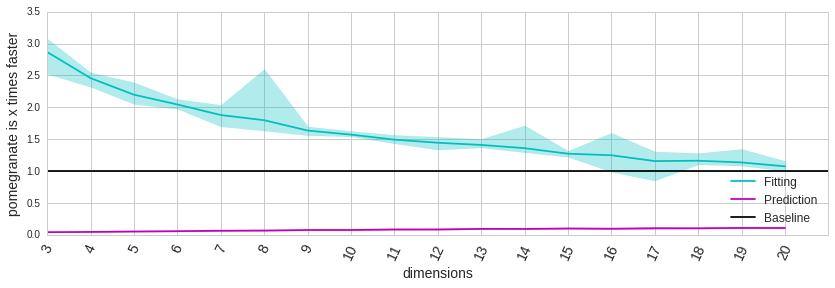

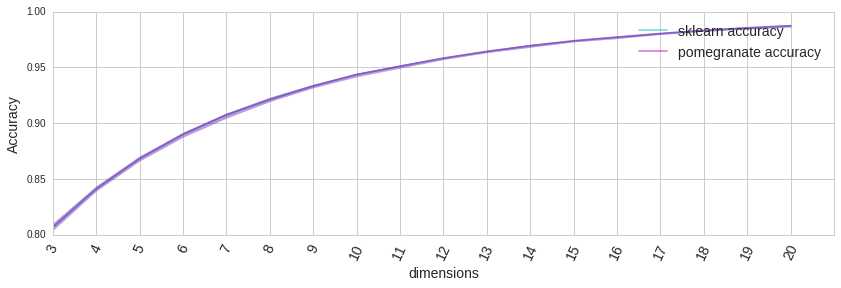

In [14]:
def evaluate_models( skl, pom ):
    sizes = numpy.arange(3, 21).astype('int')
    n, m = sizes.shape[0], 20
    
    skl_predict, pom_predict = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_fit, pom_fit = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))
    
    for i in range(m):
        for j, size in enumerate(sizes):
            X, y = create_dataset( 50000, size, 2 )
            
            # bench fit times
            tic = time.time()
            skl.fit( X, y )
            skl_fit[i, j] = time.time() - tic

            tic = time.time()
            pom.fit( X, y )
            pom_fit[i, j] = time.time() - tic

            # bench predict times
            tic = time.time()
            skl_predictions = skl.predict( X )
            skl_predict[i, j] = time.time() - tic

            tic = time.time()
            pom_predictions = pom.predict( X )
            pom_predict[i, j] = time.time() - tic
        
            # check number wrong
            skl_e = (y != skl_predictions).mean()
            pom_e = (y != pom_predictions).mean()

            skl_error[i, j] = min(skl_e, 1-skl_e)
            pom_error[i, j] = min(pom_e, 1-pom_e)
    
    fit = skl_fit / pom_fit
    predict = skl_predict / pom_predict
    
    plot(fit, predict, skl_error, pom_error, sizes, "dimensions")

skl = GaussianNB()
pom = NaiveBayes( MultivariateGaussianDistribution )
evaluate_models( skl, pom )

Looks like pomegranate does better in the low dimensional setting but eventually converges to the same as sklearn given large dimensionality and a large number of samples. Their accuracies remain identical indicating that the two are learning the same model.

## Out of Core Training

Lastly, both pomegranate and sklearn allow for out of core training by fitting on chunks of a dataset. pomegranate does this by calculating summary statistics on the dataset which are enough to allow for exact parameter updates to be done. sklearn implements this using the `model.partial_fit(X, y)` API call, whereas pomegranate uses `model.summarize(X, y)` followed by `model.from_summaries()` to update the internal parameters.  

Lets compare how long each method takes to train on 25 batches of increasing sizes and the accuracy of both methods.

In [15]:
def evaluate_models( skl, pom ):
    sizes = numpy.around( numpy.exp( numpy.arange(8, 16) ) ).astype('int')
    n, m = sizes.shape[0], 20
    
    skl_time, pom_time = numpy.zeros((m, n)), numpy.zeros((m, n))
    skl_error, pom_error = numpy.zeros((m, n)), numpy.zeros((m, n))
    
    for i in range(m):
        for j, size in enumerate(sizes):
            for l in range(5):
                X, y = create_dataset( size, 5, 2 )

                tic = time.time()
                skl.partial_fit( X, y, classes=[0, 1] )
                skl_time[i, j] += time.time() - tic

                tic = time.time()
                pom.summarize( X, y )
                pom_time[i, j] += time.time() - tic

            tic = time.time()
            pom.from_summaries()
            pom_time[i, j] += time.time() - tic

            skl_predictions = skl.predict( X )
            pom_predictions = pom.predict( X )

            skl_error[i, j] = ( y != skl_predictions ).mean()
            pom_error[i, j] = ( y != pom_predictions ).mean()
    
    fit = skl_time / pom_time
    idx = numpy.arange(fit.shape[1])
    
    plt.figure( figsize=(14, 4))
    plt.plot( fit.mean(axis=0), c='c', label="Fitting")
    plt.plot( [0, fit.shape[1]], [1, 1], c='k', label="Baseline" )
    plt.fill_between( idx, fit.min(axis=0), fit.max(axis=0), color='c', alpha=0.3 )
    
    plt.xticks(idx, sizes, rotation=65, fontsize=14)
    plt.xlabel('{}'.format(xlabel), fontsize=14)
    plt.ylabel('pomegranate is x times faster', fontsize=14)
    plt.legend(fontsize=12, loc=4)
    plt.show()
    
    
    plt.figure( figsize=(14, 4))
    plt.plot( 1 - skl_error.mean(axis=0), alpha=0.5, c='c', label="sklearn accuracy" )
    plt.plot( 1 - pom_error.mean(axis=0), alpha=0.5, c='m', label="pomegranate accuracy" )
    
    plt.fill_between( idx, 1-skl_error.min(axis=0), 1-skl_error.max(axis=0), color='c', alpha=0.3 )
    plt.fill_between( idx, 1-pom_error.min(axis=0), 1-pom_error.max(axis=0), color='m', alpha=0.3 )
    
    plt.xticks( idx, sizes, rotation=65, fontsize=14)
    plt.xlabel( '{}'.format(xlabel), fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(fontsize=14) 
    plt.show()

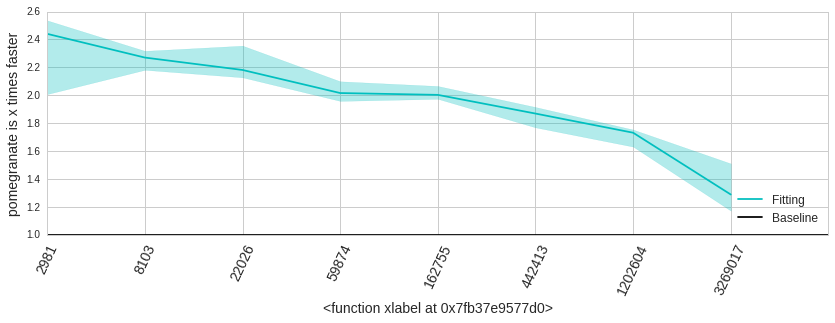

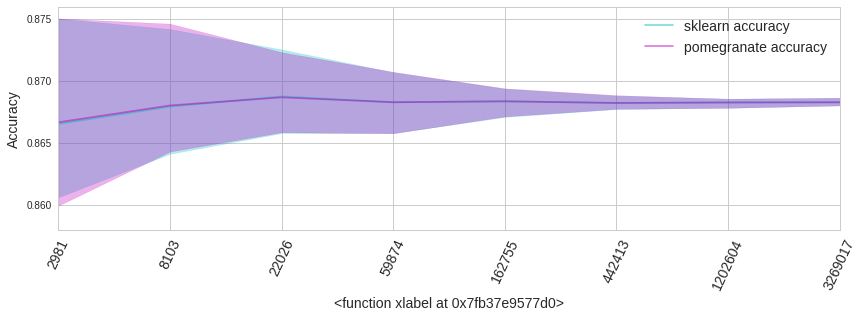

In [16]:
skl = GaussianNB()
pom = NaiveBayes( MultivariateGaussianDistribution )
evaluate_models( skl, pom )

pomegranate seems to be faster doing out-of-core training. The out of core API of calculating sufficient statistics using `summarize` and then updating the model parameters using `from_summaries` extends to all models in pomegranate. 

In this notebook we compared an intersection of the features that pomegranate and sklearn offer. pomegranate allows you to use Naive Bayes with any distribution or model object which has an exposed `log_probability` and `fit` method. This allows you to do things such as compare hidden Markov models to each other, or compare a hidden Markov model to a Markov Chain to see which one models the data better. 

We hope this has been useful to you! If you're interested in using pomegranate, you can get it using `pip install pomegranate` or by checking out the <a href="https://github.com/jmschrei/pomegranate">github repo.</a>